# Exploratory Analysis

* $RQ_1$: How does temporal proximity affect sharing behaviour during protest demonstrations?
* $RQ_2$: How do source attributes like the poster's gender affect sharing behaviour during protest demonstrations?
* $RQ_3$: Is there evidence of a "backfire effect" where misleading posts that *don't* have a credibility indicator are assumed to be true and more likely to be reshared.
* ~~$RQ_4$: Does the treatment effectiveness vary by political affiliation?~~~

In [1]:
library(lme4)
library(e1071) 
library(parameters)

data <- read.csv("../../data/processed/60b37265a9f60881975de69e-rumour-results.csv")
data$reshared <- as.integer(as.logical(data$reshared))
data$code = relevel(as.factor(data$code), ref = "neutral") 
data$evidence = relevel(as.factor(data$evidence), ref = "low") 
head(data)

Loading required package: Matrix


Attaching package: ‘parameters’


The following objects are masked from ‘package:e1071’:

    kurtosis, skewness




,user_id,condition,timeSubmitted,secondsTaken,id,rumour,code,evidence,warning,reshared,clickedWarning,timestamp,posterGender,posterId
,<dbl>,<chr>,<chr>,<int>,<dbl>,<chr>,<fct>,<fct>,<chr>,<int>,<chr>,<int>,<chr>,<chr>
1,8.434486e+18,treatment,2021-06-03 09:50:15.953000+00:00,120,1.283849e+18,R1,neutral,high,False,0,False,3,male,RnJlZGVyaWNrIFdvb2RodHRwczovL3JhbmRvbXVzZXIubWUvYXBpL3BvcnRyYWl0cy90aHVtYi9tZW4vMTkuanBn
2,8.434486e+18,treatment,2021-06-03 09:50:15.953000+00:00,120,1.283767e+18,R1,neutral,high,False,0,False,4,female,S2F0aWUgTXVycGh5aHR0cHM6Ly9yYW5kb211c2VyLm1lL2FwaS9wb3J0cmFpdHMvdGh1bWIvd29tZW4vNjQuanBn
3,8.434486e+18,treatment,2021-06-03 09:50:15.953000+00:00,120,1.283508e+18,R1,denies,high,True,0,False,11,male,R2FyeSBIb3BraW5zaHR0cHM6Ly9yYW5kb211c2VyLm1lL2FwaS9wb3J0cmFpdHMvdGh1bWIvbWVuLzc4LmpwZw==
4,8.434486e+18,treatment,2021-06-03 09:50:15.953000+00:00,120,1.283371e+18,R1,affirms,high,False,0,False,11,female,V2lsbGllIENsYXJraHR0cHM6Ly9yYW5kb211c2VyLm1lL2FwaS9wb3J0cmFpdHMvdGh1bWIvd29tZW4vNy5qcGc=
5,8.434486e+18,treatment,2021-06-03 09:50:15.953000+00:00,120,1.283538e+18,R1,affirms,high,False,1,False,13,female,TWVsaW5kYSBCYXJyZXR0aHR0cHM6Ly9yYW5kb211c2VyLm1lL2FwaS9wb3J0cmFpdHMvdGh1bWIvd29tZW4vNjIuanBn
6,8.434486e+18,treatment,2021-06-03 09:50:15.953000+00:00,120,1.283492e+18,R1,questions,high,False,1,False,14,male,TG9ubmllIE1pbGVzaHR0cHM6Ly9yYW5kb211c2VyLm1lL2FwaS9wb3J0cmFpdHMvdGh1bWIvbWVuLzEwLmpwZw==


### Binomial Logistic regression

Alt add an interaction between warning and evidence (if we expect there to be different effects for putting a cred indicator on a post denying a high evidence rumour vs affirming a low evidence rumour.

* $RQ_1$: How does temporal proximity affect sharing behaviour during protest demonstrations?
* $RQ_2$: How do source attributes like the poster's gender affect sharing behaviour during protest demonstrations?

> Our outcome variable was the intent to share the article corresponding to a headline with friends on social media. Since the outcome variable is a binary choice between the intent to share or not share, we employed Binomial Logistic Regression (BLR). The BLR incorporated participant ID and headline ID as random effects to account for repeated measures for varying items [5, 68]. Our independent variables included the treat- ment, headline category, political affiliation, social media use, and common demographic factors, such as age and gender. (Yaqub)

^ I do the same but incorporating the participant ID, source ID, and post ID to account for repeated measures, and to measure the proportion of variance explained by source and post attributes

In [2]:
md <- glmer(reshared ~ posterGender + timestamp + warning + code * evidence + (1 | user_id) + (1 | posterId) + (1 | id),
            data = data,
            family = binomial, 
            control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5))
           )
summary(md)

boundary (singular) fit: see ?isSingular



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: reshared ~ posterGender + timestamp + warning + code * evidence +  
    (1 | user_id) + (1 | posterId) + (1 | id)
   Data: data
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
  4941.5   5037.2  -2456.7   4913.5     6874 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8943 -0.3932 -0.2287 -0.1070 11.1696 

Random effects:
 Groups   Name        Variance Std.Dev.
 posterId (Intercept) 0.0000   0.0000  
 id       (Intercept) 0.6119   0.7823  
 user_id  (Intercept) 1.9216   1.3862  
Number of obs: 6888, groups:  posterId, 6887; id, 167; user_id, 125

Fixed effects:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -1.854753   0.297322  -6.238 4.43e-10 ***
posterGendermale            0.015735   0.076188   0.207  0.83638    
t

Warning message in hatvalues.merMod(model):
“the hat matrix may not make sense for GLMMs”


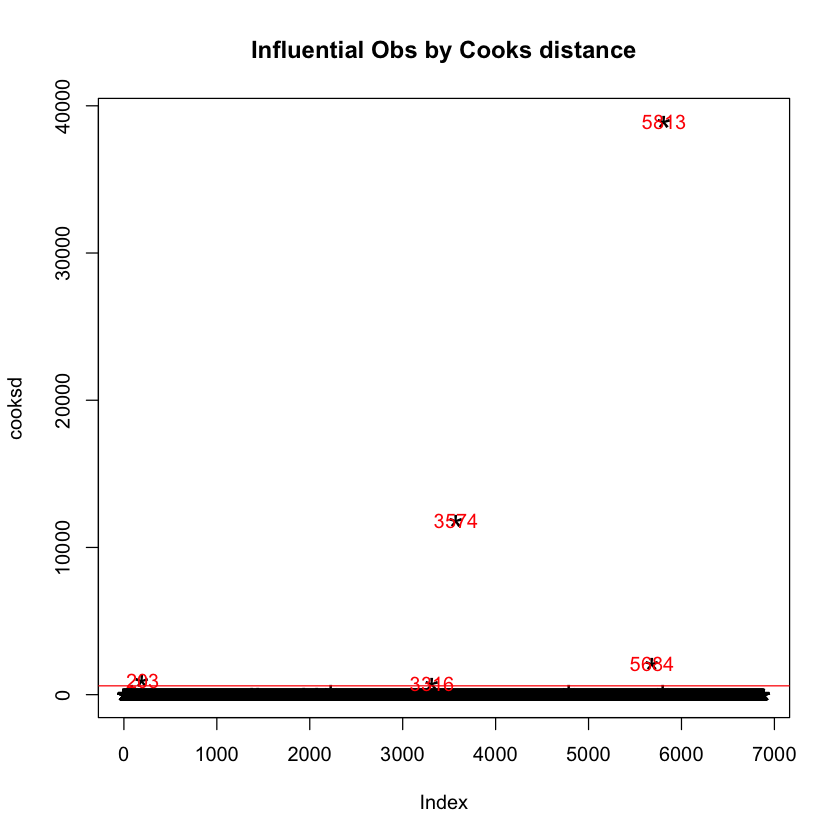

In [3]:
cooksd <- cooks.distance(md)
thresh <- 600

# Plot the Cook's Distance using the traditional 4/n criterion
sample_size <- nrow(data)
plot(cooksd, pch="*", cex=2, main="Influential Obs by Cooks distance")  # plot cook's distance
abline(h = thresh, col="red")  # add cutoff line
text(x=1:length(cooksd)+1, y=cooksd, labels=ifelse(cooksd>thresh, names(cooksd),""), col="red")  # add label

In [4]:
md.cooksRemoved <- glmer(reshared ~ posterGender + timestamp + warning + code * evidence + (1 | user_id) + (1 | posterId) + (1 | id),
            data = data,
            family = binomial, 
            control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)),
            subset = cooksd<=thresh)
summary(md)

boundary (singular) fit: see ?isSingular



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: reshared ~ posterGender + timestamp + warning + code * evidence +  
    (1 | user_id) + (1 | posterId) + (1 | id)
   Data: data
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
  4941.5   5037.2  -2456.7   4913.5     6874 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8943 -0.3932 -0.2287 -0.1070 11.1696 

Random effects:
 Groups   Name        Variance Std.Dev.
 posterId (Intercept) 0.0000   0.0000  
 id       (Intercept) 0.6119   0.7823  
 user_id  (Intercept) 1.9216   1.3862  
Number of obs: 6888, groups:  posterId, 6887; id, 167; user_id, 125

Fixed effects:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -1.854753   0.297322  -6.238 4.43e-10 ***
posterGendermale            0.015735   0.076188   0.207  0.83638    
t

In [14]:
md.treatEffect <- glmer(reshared ~ posterGender + timestamp + warning + code * evidence + (1 + condition | user_id) + (1 | posterId) + (1 | id),
            data = data,
            family = binomial, 
            control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)))
summary(md)

boundary (singular) fit: see ?isSingular



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: reshared ~ posterGender + timestamp + warning + code * evidence +  
    (1 | user_id) + (1 | posterId) + (1 | id)
   Data: data
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
  4941.5   5037.2  -2456.7   4913.5     6874 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8943 -0.3932 -0.2287 -0.1070 11.1696 

Random effects:
 Groups   Name        Variance Std.Dev.
 posterId (Intercept) 0.0000   0.0000  
 id       (Intercept) 0.6119   0.7823  
 user_id  (Intercept) 1.9216   1.3862  
Number of obs: 6888, groups:  posterId, 6887; id, 167; user_id, 125

Fixed effects:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -1.854753   0.297322  -6.238 4.43e-10 ***
posterGendermale            0.015735   0.076188   0.207  0.83638    
t

In [15]:
anova(md,md.treatEffect)

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
md,14,4941.479,5037.204,-2456.739,4913.479,NA,NA,NA
md.treatEffect,16,4945.338,5054.738,-2456.669,4913.338,0.1407973,2,0.9320222


NULL